In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import os

In [2]:
# For using Google Colab only
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


base_path = '/content/drive/MyDrive/Data'

# Trade data
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Australia.xlsx'
trade_australia = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Canada.xlsx'
trade_canada = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_China.xlsx'
trade_china = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_Kingdom.xlsx'
trade_uk = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_States_of_America.xlsx'
trade_usa = pd.read_excel(trade_path, skiprows=4, header=[0, 1])

# Economic indicators
changing_scenarios = pd.read_excel('/content/drive/MyDrive/Data/Copy of changing scenerio.xlsx')


# Specify the folder path for economic data (only once)
economic_path = '/content/drive/MyDrive/Data/Data2/GDP etc/'

# Read the 'Expense.xlsx' file
expense = pd.read_excel(economic_path + 'Expense.xlsx', skiprows=4, header=[0, 1])
gdp_growth = pd.read_excel(economic_path + 'GDP growth.xlsx', skiprows=4, header=[0, 1])
inflation = pd.read_excel(economic_path + 'Inflation.xlsx', skiprows=4, header=[0, 1])
net_investment = pd.read_excel(economic_path + 'Net investment.xlsx', skiprows=4, header=[0, 1])

# Specify the folder path for import trade data (only once)
import_path = '/content/drive/MyDrive/Data/Data2/Import and Import from world/'

# Read the 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx' file
import_trade_canada = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx', skiprows=4, header=[0, 1])
import_trade_china = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_China.xlsx', skiprows=4, header=[0, 1])
import_trade_india = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_India.xlsx', skiprows=4, header=[0, 1])
import_trade_uk = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_Kingdom.xlsx', skiprows=4, header=[0, 1])
import_trade_usa = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_State_of_America.xlsx', skiprows=4, header=[0, 1])

In [4]:
trade_usa.head()

Product code                                      Product label  \
  Unnamed: 0_level_1                                 Unnamed: 1_level_1   
0             'TOTAL                                       All products   
1                '01                                       Live animals   
2                '02                         Meat and edible meat offal   
3                '03  Fish and crustaceans, molluscs and other aquat...   
4                '04  Dairy produce; birds' eggs; natural honey; edi...   

  United Arab Emirates's exports to United States of America                \
                                               Value in 2003 Value in 2004   
0                                                NaN                   NaN   
1                                                NaN                   NaN   
2                                                NaN                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   

                                                                         \
  Value in 2005 Value in 2006 Value in 2007 Value in 2008 Value in 2009   
0        796518           NaN        699712       1230163           NaN   
1           246           NaN            20            27           NaN   
2            52           NaN           122            62           NaN   
3         20507           NaN         11214          4646           NaN   
4           379           NaN           134           267           NaN   

                 ... United Arab Emirates's exports to world                \
  Value in 2010  ...                           Value in 2013 Value in 2014   
0           NaN  ...                               371217682     343043070   
1           NaN  ...                                   59638        359214   
2           NaN  ...                                   81831         66076   
3           NaN  ...                                  128652        114418   
4           NaN  ...                                  374787        439388   

                                                                         \
  Value in 2015 Value in 2016 Value in 2017 Value in 2018 Value in 2019   
0     300478648     295046691     313547597     321006905     315942728   
1         57364         46087         42979         90455         56361   
2         49031         53463         70800        244690        652931   
3        114360        123412         76224        212978        190332   
4        642173        470889        539346        945655        988080   

                                             
  Value in 2020 Value in 2021 Value in 2022  
0     335296908     425159797     311313710  
1         42405         30095         23998  
2        258430        357568         28133  
3        140263        132971        234334  
4        881124        945101         84495  

[5 rows x 64 columns]

In [5]:
trade_usa.shape

(98, 64)

In [6]:
second_column = import_trade_usa.iloc[:, 1]  # Index 1 corresponds to the second column
print(second_column)

0                                          All products
1                                          Live animals
2                            Meat and edible meat offal
3     Fish and crustaceans, molluscs and other aquat...
4     Dairy produce; birds' eggs; natural honey; edi...
                            ...                        
93    Furniture; bedding, mattresses, mattress suppo...
94    Toys, games and sports requisites; parts and a...
95                  Miscellaneous manufactured articles
96        Works of art, collectors' pieces and antiques
97                  Commodities not elsewhere specified
Name: (Product label, Unnamed: 1_level_1), Length: 98, dtype: object


In [7]:
def clean_trade_data(df):
    # Drop rows with NaN values in the first 5 columns
    df = df.dropna(subset=df.columns[:5], how='all')

    # Rename columns
    df.columns = [' '.join(map(str, col)).strip() if 'Unnamed' not in col else str(col[0]) for col in df.columns.values]

    # Simplify column names
    new_columns = []
    for col in df.columns:
        if 'Value in' in col:
            new_columns.append(col.split()[-1])  # Just the year
        elif 'Product code' in col:
            new_columns.append('Product Code')
        elif 'Product label' in col:
            new_columns.append('Product Label')
        else:
            new_columns.append(col)  # The first part of the tuple
    df.columns = new_columns

    # Drop columns and rows that are completely NaN
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df


In [302]:
df=clean_trade_data(import_trade_canada)  # selecting desired import ,export country

In [303]:
df.head()

,Product Code,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,'TOTAL,All products,352536,657414,1243673,1806813,1739279,1721740,1737375,1542536,...,294955904,298608729,287024695,270779149,273710850,261510757,267937296,246961071,347528998,248626440
1,'01,Live animals,149,41,41,11,33,102,41,128,...,238531,269309,288170,204226,195582,114961,115420,109286,124123,117418
2,'02,Meat and edible meat offal,147,249,994,4953,5618,5705,4650,5521,...,1572532,1590308,1663314,1626971,1705968,1870160,2281642,1752583,2030354,2405744
3,'03,"Fish and crustaceans, molluscs and other aquat...",980,1704,2023,2575,2186,2164,2015,2425,...,438378,575996,514124,552588,617538,649060,647939,590170,647185,503421
4,'04,Dairy produce; birds' eggs; natural honey; edi...,422,2012,999,3674,1975,1845,1417,1320,...,1463353,1778903,1588084,1438793,1816500,1851023,1726308,1747003,1730067,1322676


In [304]:
# dropping product code column
df = df.drop(df.columns[0], axis=1)

In [305]:
df.head()

,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,2017,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,All products,352536,657414,1243673,1806813,1739279,1721740,1737375,1542536,1921761,...,294955904,298608729,287024695,270779149,273710850,261510757,267937296,246961071,347528998,248626440
1,Live animals,149,41,41,11,33,102,41,128,50,...,238531,269309,288170,204226,195582,114961,115420,109286,124123,117418
2,Meat and edible meat offal,147,249,994,4953,5618,5705,4650,5521,6072,...,1572532,1590308,1663314,1626971,1705968,1870160,2281642,1752583,2030354,2405744
3,"Fish and crustaceans, molluscs and other aquat...",980,1704,2023,2575,2186,2164,2015,2425,5211,...,438378,575996,514124,552588,617538,649060,647939,590170,647185,503421
4,Dairy produce; birds' eggs; natural honey; edi...,422,2012,999,3674,1975,1845,1417,1320,2845,...,1463353,1778903,1588084,1438793,1816500,1851023,1726308,1747003,1730067,1322676


In [306]:
# selecting desired product by index
df=df.iloc[1]

In [307]:
df.head()

Product Label    Live animals
2005                      149
2007                       41
2008                       41
2012                       11
Name: 1, dtype: object

In [308]:
print(df)

Product Label    Live animals
2005                      149
2007                       41
2008                       41
2012                       11
2013                       33
2014                      102
2015                       41
2016                      128
2017                       50
2018                       79
2019                       53
2020                      624
2021                       47
2003                   932709
2004                   659980
2005                  1266325
2006                  1772424
2007                  2260800
2008                  2192972
2009                  1433360
2010                  1626397
2011                  1435682
2012                  1621261
2013                  1824440
2014                  2445299
2015                  1919095
2016                  1613485
2017                  1436377
2018                  1322278
2019                  1492401
2020                  1359591
2021                  1689033
2022      

In [309]:
# Remove the title rows without affecting the columns
df = df.iloc[2:]

In [310]:
df=pd.DataFrame(df)

In [311]:
df.head()

,1
2007,41
2008,41
2012,11
2013,33
2014,102


In [312]:
# selecting first 12 rows since after that data is for import or export to world
df = df.iloc[12:]

print(df)

            1
2003   932709
2004   659980
2005  1266325
2006  1772424
2007  2260800
2008  2192972
2009  1433360
2010  1626397
2011  1435682
2012  1621261
2013  1824440
2014  2445299
2015  1919095
2016  1613485
2017  1436377
2018  1322278
2019  1492401
2020  1359591
2021  1689033
2022  1962563
2005   120401
2007   104962
2008   160937
2012   176010
2013   238531
2014   269309
2015   288170
2016   204226
2017   195582
2018   114961
2019   115420
2020   109286
2021   124123
2022   117418


<Axes: >

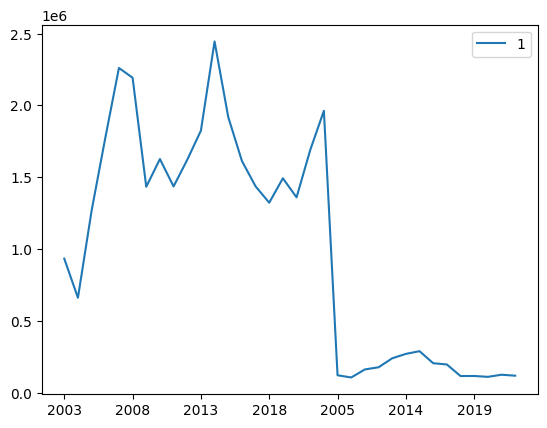

In [313]:
df.plot()

In [314]:

# Convert the years column to a datetime index and set the column name as 'Date'
df.index = pd.to_datetime(df.index, format='%Y')
df.index.name = 'Date'

print(df)


                  1
Date               
2003-01-01   932709
2004-01-01   659980
2005-01-01  1266325
2006-01-01  1772424
2007-01-01  2260800
2008-01-01  2192972
2009-01-01  1433360
2010-01-01  1626397
2011-01-01  1435682
2012-01-01  1621261
2013-01-01  1824440
2014-01-01  2445299
2015-01-01  1919095
2016-01-01  1613485
2017-01-01  1436377
2018-01-01  1322278
2019-01-01  1492401
2020-01-01  1359591
2021-01-01  1689033
2022-01-01  1962563
2005-01-01   120401
2007-01-01   104962
2008-01-01   160937
2012-01-01   176010
2013-01-01   238531
2014-01-01   269309
2015-01-01   288170
2016-01-01   204226
2017-01-01   195582
2018-01-01   114961
2019-01-01   115420
2020-01-01   109286
2021-01-01   124123
2022-01-01   117418


In [315]:
df = df.rename(columns={1: 'Values'})

In [316]:
df.head()

,Values
Date,
2003-01-01,932709
2004-01-01,659980
2005-01-01,1266325
2006-01-01,1772424
2007-01-01,2260800


In [317]:
df.to_csv('output.csv', index=False)

<Axes: xlabel='Date'>

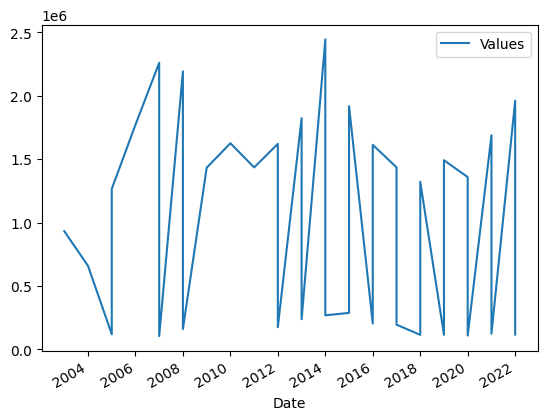

In [318]:
df.plot()

In [319]:


df=pd.read_csv('output.csv')

<Axes: >

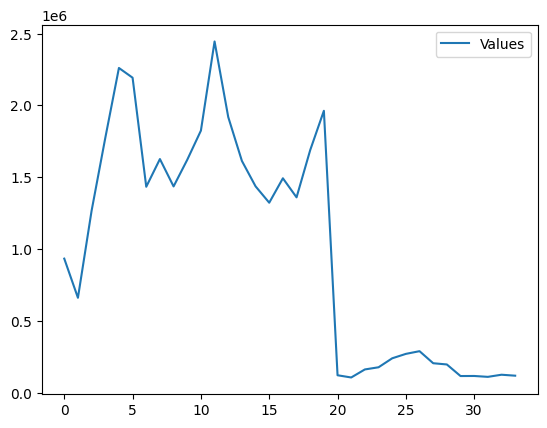

In [320]:
df.plot()

In [321]:
train_size = int(len(df)*0.7)

train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]

In [322]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)
rmse = []
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

In [323]:
list(train.columns)

['Values']

In [324]:
len(train), len(test)

(31, 3)

In [325]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []

    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])

    return np.array(xs), np.array(ys)

In [326]:
xtrain, ytrain = create_dataset(train, train.Values,1)
xtest, ytest = create_dataset(test, test.Values,1)

In [327]:
ytrain

array([ 659980, 1266325, 1772424, 2260800, 2192972, 1433360, 1626397,
       1435682, 1621261, 1824440, 2445299, 1919095, 1613485, 1436377,
       1322278, 1492401, 1359591, 1689033, 1962563,  120401,  104962,
        160937,  176010,  238531,  269309,  288170,  204226,  195582,
        114961,  115420])

In [328]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler_y = StandardScaler()

# Reshape y_train to a 2D array and then fit and transform it
ytrain = ytrain.reshape(-1, 1)
ytrain = scaler_y.fit_transform(ytrain)

# Now, y_train_scaled contains the standardized values of y_train


In [329]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True))  # Return sequences for subsequent LSTM layers
model.add(LSTM(50, activation='relu', return_sequences=True))  # Add more LSTM layers
model.add(LSTM(50, activation='relu'))  # Add more LSTM layers
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")


In [330]:
model.fit(xtrain, ytrain,
         epochs=200,
         batch_size=1,
         verbose=1,
         shuffle=False
         )

Epoch 1/200
30/30 [==============================] - 4s 8ms/step - loss: 67107.8672
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 7005.4634
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 2980.5830
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 14.7137
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 7.1945
Epoch 6/200
30/30 [==============================] - 0s 7ms/step - loss: 1.0194
Epoch 7/200
30/30 [==============================] - 0s 8ms/step - loss: 12.0417
Epoch 8/200
30/30 [==============================] - 0s 8ms/step - loss: 39.7525
Epoch 9/200
30/30 [==============================] - 0s 7ms/step - loss: 202.4830
Epoch 10/200
30/30 [==============================] - 0s 8ms/step - loss: 861.1218
Epoch 11/200
30/30 [==============================] - 0s 6ms/step - loss: 2672.5886
Epoch 12/200
30/30 [==============================] - 0s 9ms/step - loss: 5120.5493
Epoch 13/200
3

In [331]:
ypred = model.predict(xtrain)

1/1 [==============================] - 0s 415ms/step


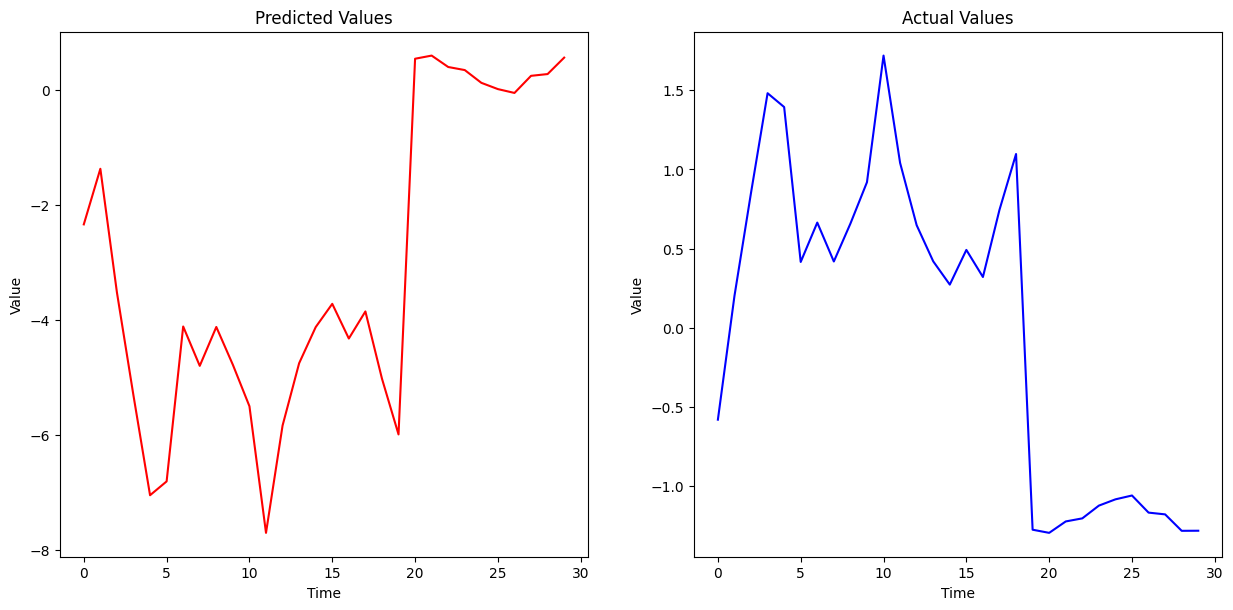

In [332]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()


In [333]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ypred = scaler_y.inverse_transform(ypred)


In [334]:
# Reshape y_train to its original form
ypred = ypred.reshape(-1)


In [335]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ytrain = scaler_y.inverse_transform(ytrain)


In [336]:
# Reshape y_train to its original form
ytrain = ytrain.reshape(-1)


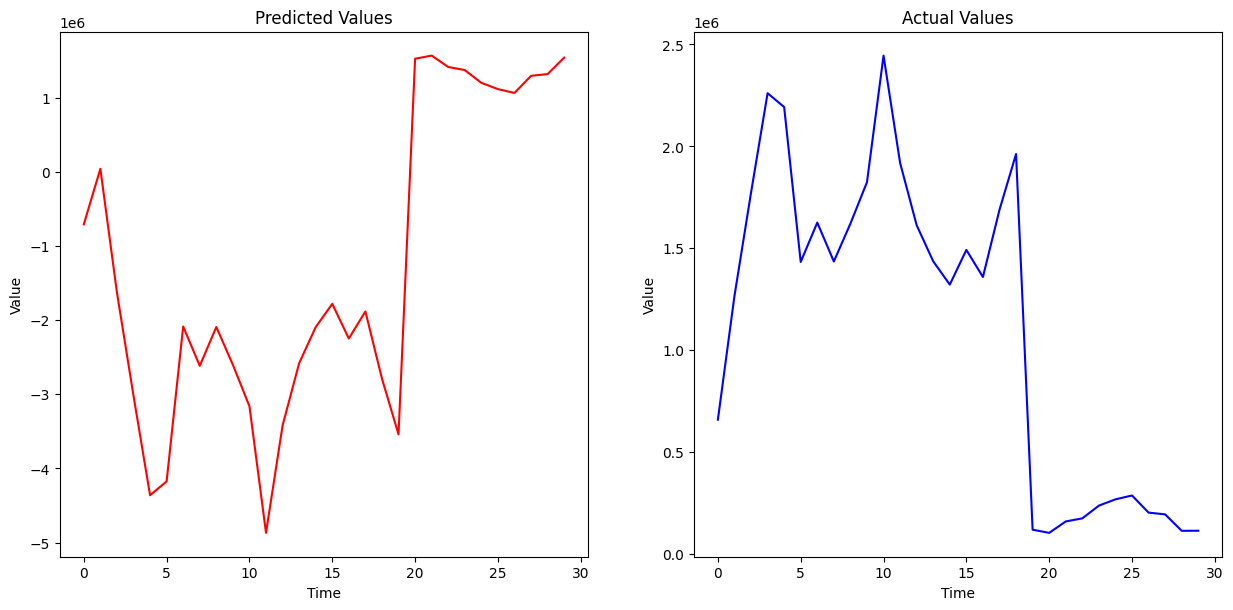

In [337]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()
